In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import math

# loads the pre-processed variables
%run load_helper.ipynb
#

# ##################################################
#
# QUICK START
# For each run
#       pick baseline
#       name your run
#       SET UP PARAMETERS
#       then hit run
#       if you wish to display the top words from significant topics see the word plot cell
#       if you wish to visualize the topics for that run run the visualization cell
# Repeat for a few runs
#
# Run the plotting cell
#
# NOTE: You may want to clean out files from the Run_data directory first
#       It can get quite large 
#
# NOTE: If you run the visualiztion cell, and then run another iteration
#       you may get deprecation warnings (the visualization tool has not been updated)
#       you can ignore those warnings - or reset the kernel from the kernel menu above before the run
#
# ##################################################


# ##################################################
#
# pick a baseline
#        baselines = ["10topics2", "15topics2", "20topics2", "25topics2", "30topics2"]
#
# NAME YOUR RUN (used to store the iterations); models will be saved myrun1.sav myrun2.save etc
#
# ##################################################

# ##################################################
#
# set your global parameters
#
# NOTE if you want to run the algorithm from the paper
#      set classical to 'y'
#
#      if you want to run the 'improved' algorithm
#      set classical to 'n'
#
#      then set parameters in next section
#
# ##################################################
mybaseline = "30baseline2"
runname = "Improved30T8I"
#runname = "ClassicLowDecay"

classical = 'n'      # 'y' to run classical 'n' to run improved
                     # if 'y' set parameters in the next section

# ##################################################
# classical = 'n' 
# "Improved"
# ##################################################
lda_decay = float(.5)      # how much the prior influences the iteration 0 - 1 
                           #      mathmatically anything less than .5 is not guartenteed to converge
                           #      however we have tuned the model to work down to .001 (and possibly lower)
                           # if you do set this too low, Gensim will display warnings
            
num_iterations = 8  # NOTE this is in addition to baseline so if you want 14 results set this to 13 (0 is a counting word)
                     # our tuning says to set this to about 13

the_lag = 5 # lag of 5 is mentioned in the paper, and seems to work twith trial runs

# ##################################################
# classical = 'y' 
# ##################################################

num_iterations_c = 4           # if you are going to use the algorthim in the paper (with splitting) set to around 4
lda_decay_c = float(.5)        # how much the prior influences the iteration 0 - 1 
the_lag_c = 5                  # lag of 5 is mentioned in the paper, and seems to work twith trial runs

num_buffers = 0                   # how many buffers to add each iteration
drop_percent = float(.95)         # as indicited in the paper, drop below .95 percent
low_threshold = float(.05)        # threshold for the p-values .05 is pretty much expected
ignore_little_counts = float(.2)  # if pos/neg words dominate, ignore the other topic



# ##################################################
#
# The ITMFT algorithm
#
# ##################################################

iteration = 0
vis_name = ""
itstoskip = 3
#
# load the baseline selected in the parameters above
#
if classical == 'y'  :
    lda_decay =  lda_decay_c
    num_iterations = num_iterations_c
    the_lag = the_lag_c


file_name = baseline_path + mybaseline + ".sav"
model = LdaModel.load(file_name)
    
topics = model.get_topics().copy()
topics = topics.copy()
num_topics = len(topics)
print("Number of Topics = ", num_topics)

run_purity = []
run_confidence = []

mostsigtopics = []
mostsigtopicwords = []
mostsigconf = float(2.0)

#
# loop through the iterations
#
while iteration < num_iterations  :
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("\nIteration start time = ", current_time)
    
    # 
    # run either the "classical" or the "improved" algorithm
    #
    if classical == 'y'  :
        %run itmtf_withsplit.ipynb 
    else :
        %run itmtf_improved.ipynb 
    
    #
    # run the model
    #
    model = LdaModel(
        corpus=corpus,
        id2word=tokentoword,
        chunksize=chunksize,
        alpha='auto',               
        eta=newtopics,                 # preset topic/word
        iterations=iterations,
        num_topics=num_topics,         # added buffer topics
        passes=passes,
        decay = lda_decay,
        eval_every=eval_every
    )

    topics = model.get_topics().copy()
    num_topics = len(topics)
 
    file_name = runname + str(iteration) 
    path_name = save_path + file_name + ".sav"
    print("Model " + file_name + " - saved for visualization")
    model.save(path_name )
    iteration += 1

#
# after the iterations are done
# run the algorithm once more to gather stats from the last model
#
if classical == 'y'  :
    %run itmtf_withsplit.ipynb 
else :
    %run itmtf_improved.ipynb 
#
file_name = runname + str(iteration) 
path_name = save_path + file_name + ".sav"
print("Model " + file_name + " - saved for visualization")
model.save(path_name )

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Run Complete = ", current_time)
 
print ("Significant Topics", mostsigtopics)

#
# save the stats
#
path_name = save_path + runname + ".sigwords.csv"
fo = open(path_name, "w")
firstime = 0
for ii in range (0, len(mostsigtopics)) :
    fo.write(str(mostsigtopics[ii]))
    words = " "
    for yy in range (0,10) :
        if pearsoncorr[mostsigtopicwords[ii][yy][0]] > 0 :
            words = words + ",B+: " + tokentoword[mostsigtopicwords[ii][yy][0]]
        else :
            words = words + ",G+: " + tokentoword[mostsigtopicwords[ii][yy][0]]
    words = words + "\n"
    fo.write(words) 
fo.close()  

path_name = save_path + runname + ".run.confidence.csv"
fo = open(path_name, "w")
firstime = 0
for num in run_confidence :
    if firstime == 0 :
        fo.write(str(num) )
        firstime = 1
    else :      
        fo.write("\n" + str(num))                 
fo.close()   

if classical == 'y'  :
    path_name = save_path + runname + ".run.purity.csv"
    fo = open(path_name, "w")
    firstime = 0
    for num in run_purity :
        if firstime == 0 :
            fo.write(str(num) )
            firstime = 1
        else :      
            fo.write("\n" + str(num))                 
    fo.close()   


Number of time slices with docs: 123
Number of time slices: 123
Number of time vocab: 12517
Size of doctokens: 2673
Number of documents: 2673
Number of unique tokens: 12517
Pearsons correlation: 12517
Pearsons/Granger correlation: 12517
Number of Topics =  30

Iteration start time =  15:33:08
causality_confidence =  0.7522505068942196
Model Improved30T8I0 - saved for visualization

Iteration start time =  15:34:32
causality_confidence =  0.7512659003353286
Model Improved30T8I1 - saved for visualization

Iteration start time =  15:36:00
causality_confidence =  0.7370334877860056
Model Improved30T8I2 - saved for visualization

Iteration start time =  15:37:40

Significant Topics:  [0, 3, 12, 16, 17, 20, 23]
causality_confidence =  0.7749176224019498
Model Improved30T8I3 - saved for visualization

Iteration start time =  15:39:10

Significant Topics:  [1, 2, 4, 8, 9, 11, 22, 24, 26, 29]
causality_confidence =  0.8134942442812825
Model Improved30T8I4 - saved for visualization

Iteration st

In [5]:
# After each run
# display the top 10 words for each significant topic

# or display the words for any saved run
#path_name = ".\Run_data\Improved30T14I.sigwords.csv"
path_name = save_path + runname + ".sigwords.csv"
%run run_words.ipynb
draw_grid(path_name)

4  |B+: bush |G+: governor |G+: texas |G+: hispanic |G+: black |G+: george |G+: percent |G+: president |B+: bushs |G+: mexico

8  |G+: gore |B+: gores |G+: clinton |G+: president |G+: al |B+: bush |B+: vice |G+: campaign |G+: lieberman |G+: democratic

9  |G+: gore |B+: bush |G+: debate |G+: al |G+: george |G+: president |B+: vice |B+: debates |G+: gov |B+: million

10  |B+: bush |G+: gore |B+: military |G+: president |G+: american |G+: george |B+: foreign |B+: war |G+: policy |B+: bushs

11  |G+: gore |B+: tax |B+: bush |G+: president |B+: plan |G+: social |B+: cut |G+: security |G+: al |B+: bushs

12  |G+: gore |B+: bush |B+: gores |G+: economic |G+: families |B+: plan |B+: tax |G+: president |G+: al |G+: family

13  |B+: bush |G+: gore |G+: campaign |G+: george |G+: president |B+: bushs |G+: al |G+: texas |G+: governor |G+: gov

21  |B+: bush |G+: gore |G+: percent |G+: voters |G+: president |B+: poll |B+: bushs |B+: vice |B+: gores |G+: campaign

23  |G+: gore |B+: bush |G+: lieber

In [ ]:
import pyLDAvis
import pyLDAvis.gensim  

# After a run
# you can view the topics with this tool
# it will display the model that the run has determined was the most significant
#
# Note: the numbering of the topics on this tool does not correspond to the topic number above
#       this tool will show "relevant" terms - which mean frequency
#       with the topic number in the tool representing topics in decending order of word frequency
#
#       But it is interesting to visualize
#
#       Top words are also stored in the Run_data directory 
#           with the name being RunName.sigwords.csv

# NOTE
# This library has not been updated for a while
# it may give deprecation warnings
# you can ignor those

# you can select any model that was stored for visualization
#vismodel = LdaModel.load(".\Run_data\Improved14Iteration13.sav")
vismodel = LdaModel.load(vis_name)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(vismodel, corpus, dictionary)
vis

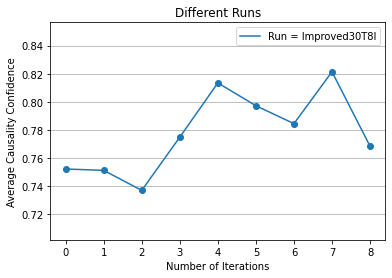

In [8]:
# After you are finished with your runs
# plot the run statistics
#plotpath = ".\\Run_data\\"

#plotpath = ".\\Improved_baseline\\"
#plotpath = ".\Classic_baseline\\"
plotpath = save_path
%run run_plot.ipynb
plot_run(plotpath)
